In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


from sklearn import datasets, svm, metrics


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits

from tqdm import tqdm_notebook as tqdm

from scipy.stats import uniform as sp_rand


# The digits dataset
digits = load_digits()
digits.data.shape

(1797, 64)

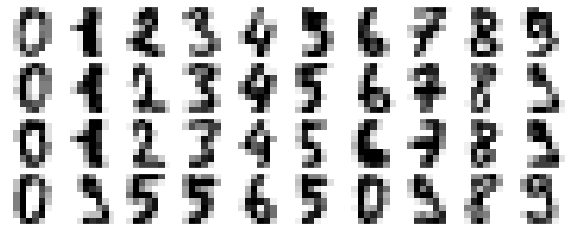

In [2]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

### PCA & Choosing Number of Components

Our goal was to preserve 80% of the information, so we will identify the number of components corresponding to 80% variation

In [3]:
# Split into Test/Train sets with 70/30 split and Standard Scaler transformation
X_trn, X_test, Y_trn, Y_test = train_test_split(digits.data, digits.target, test_size=0.30,
                                               stratify=digits.target, random_state=30)

scaler = StandardScaler()
X_trn = scaler.fit_transform(X_trn)
X_test = scaler.transform(X_test)

print("train feature shape: ", X_trn.shape)
print("test feature shape ", X_test.shape)

train feature shape:  (1257, 64)
test feature shape  (540, 64)


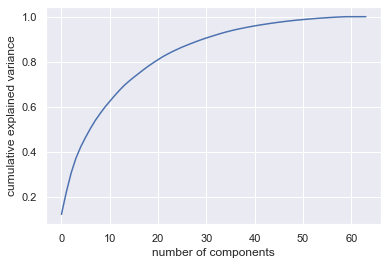

In [4]:
pca = PCA().fit(X_trn)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [5]:
# Cumulative Variance Explained Enumerated
np.cumsum(pca.explained_variance_ratio_)

array([0.12348114, 0.22169609, 0.30676355, 0.37305307, 0.42351058,
       0.46551168, 0.50455   , 0.53985978, 0.57041557, 0.59931627,
       0.62474822, 0.64987757, 0.67353609, 0.69542639, 0.71446389,
       0.73188777, 0.74866383, 0.76525644, 0.78115562, 0.79568118,
       0.80957293, 0.82305987, 0.83460391, 0.84567719, 0.85563083,
       0.86535133, 0.87408501, 0.88246182, 0.89073164, 0.89846965,
       0.90576984, 0.91258247, 0.91920896, 0.92572742, 0.93172343,
       0.9372289 , 0.9424064 , 0.94687766, 0.95129552, 0.95541527,
       0.95932418, 0.96284021, 0.96623546, 0.96948794, 0.97255433,
       0.97549287, 0.97824453, 0.98076534, 0.98308858, 0.98530889,
       0.98728888, 0.98919876, 0.99094681, 0.99262107, 0.99416738,
       0.99561001, 0.99693007, 0.9982084 , 0.99919227, 1.        ,
       1.        , 1.        , 1.        , 1.        ])

#### Number of Components Selected: 20
 * Consultation of both the cumulative variance plot and the enumeration array indicated that the data can be reduced to 20 components and still retain 80% information

### Transform/Inverse-Transform
 * Compare side-by-side of original data and PC transformed/projected data with reduction to 20 components

In [6]:
# Compute the components and projected faces
pca = PCA(20).fit(digits.data)
components = pca.transform(digits.data)
projected = pca.inverse_transform(components)

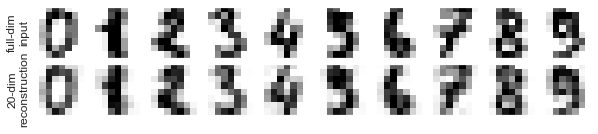

In [7]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2),
                    subplot_kw={'xticks':[], 'yticks':[]},
                    gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(digits.data[i].reshape(8, 8), cmap='binary', interpolation = 'nearest')
    ax[1, i].imshow(projected[i].reshape(8, 8), cmap='binary', interpolation = 'nearest',
                   clim=(0,16))

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('20-dim\nreconstruction');



### Moving On to SVM Classification

In [8]:
# Fit/transform data
pca = PCA(n_components=20)
X_trn = pca.fit_transform(X_trn)
X_test = pca.transform(X_test)

In [9]:
dfpca = pd.DataFrame(X_trn, columns = ['PC1','PC2','PC3','PC4', 'PC5','PC6','PC7','PC8','PC9','PC10',
                                      'PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20'])
dfpca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-0.909439,1.785094,4.107700,0.000373,-0.458999,0.098982,-0.698563,1.324110,-0.869326,-0.358067,-0.779090,-0.700580,-0.581857,0.804597,0.219780,1.078441,-0.102150,0.281895,-0.309039,-1.042681
1,4.080575,-0.336998,-0.313478,-2.703178,-1.637731,1.039190,1.675807,-1.099455,1.560119,1.406496,0.230745,-1.560922,-0.709921,-0.332890,-0.244705,-0.269142,0.204541,-0.167054,-0.249992,-0.166110
2,0.927383,-2.943809,-0.435001,-0.817941,0.547379,-0.168568,-1.680073,-2.430812,-0.549613,0.580531,-0.925586,-0.054682,-0.458533,1.598588,-1.304665,0.367356,0.901078,0.034129,0.386383,-1.472253
3,1.847741,-4.189159,-1.849855,0.401531,0.826420,-0.331457,0.619954,-1.463184,0.125386,-1.468968,1.038869,-0.307409,0.000225,-0.857296,0.138203,-0.499082,-0.158991,-0.426716,-0.332937,-0.246757
4,5.178071,-0.935118,-1.276019,1.528798,-0.903083,-0.858107,0.000837,0.534583,1.534500,2.435395,-0.573238,0.553102,0.271635,-1.237891,-0.198263,-0.161690,0.646357,0.103352,0.384055,0.572377


In [10]:
# Variance Contributions -> Rescaled to Indicate Relative Importance
fvar = np.var(dfpca, axis = 0)
fvar_rat = fvar/np.sum(fvar)
print("Variance ratio of the 20 PCA groups is ", fvar_rat)

Variance ratio of the 20 PCA groups is  PC1     0.155203
PC2     0.123446
PC3     0.106921
PC4     0.083319
PC5     0.063420
PC6     0.052791
PC7     0.049067
PC8     0.044381
PC9     0.038405
PC10    0.036325
PC11    0.031965
PC12    0.031585
PC13    0.029736
PC14    0.027512
PC15    0.023927
PC16    0.021891
PC17    0.021082
PC18    0.020854
PC19    0.019956
PC20    0.018218
dtype: float64


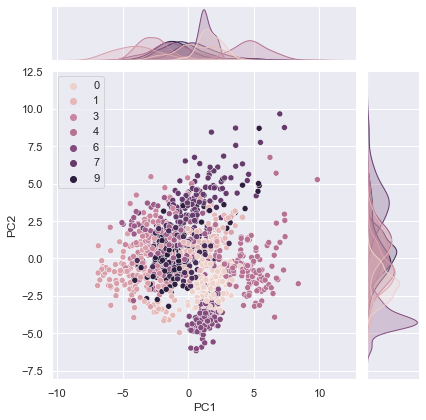

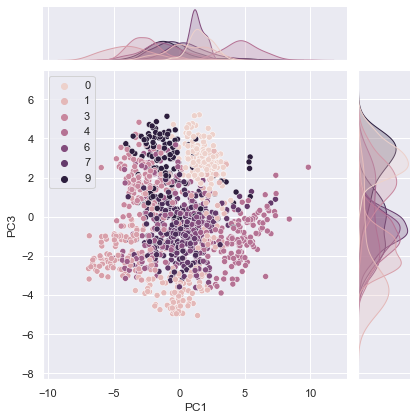

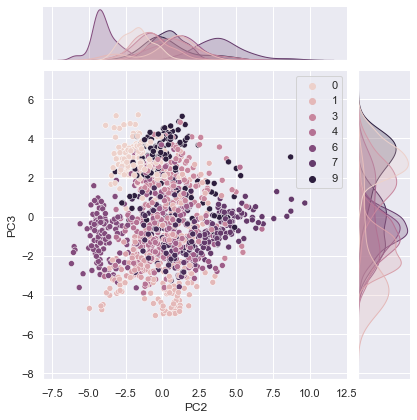

In [11]:
# Visualization of Digit/Class Separation with top 3 PCs
sns.jointplot(x = dfpca['PC1'], y = dfpca['PC2'], hue = Y_trn)
sns.jointplot(x = dfpca['PC1'], y = dfpca['PC3'], hue = Y_trn)
sns.jointplot(x = dfpca['PC2'], y = dfpca['PC3'], hue = Y_trn)

### Define Accuracy Report
 * Borrowed from https://www.analyticsvidhya.com/blog/2021/07/svm-and-pca-tutorial-for-beginners/

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def print_score(clf, X_trn, Y_trn, X_test, Y_test, train=True):
    if train:
        pred = clf.predict(X_trn)
        clf_report = pd.DataFrame(classification_report(Y_trn, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(Y_trn, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(Y_trn, pred)}\n")
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(Y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(Y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(Y_test, pred)}\n")

### Hyperparameter Tuning for SVM using RandomizedSearchCV 
 * Now that we've identified 20 PCs and transformed our data, we will select hyperparameters for use in SVM
 * We will use a RandomizedSearchCV method with linear, rbf, and polynomial kernels and compare classification scores

#### Polynomial Kernel

In [22]:
# Hyperparameter Tuning for Polynomial Kernel
param_grid = {'C': sp_rand(0,1000), 
              'gamma': sp_rand(0,50), 
              'kernel': ['poly'],
              'degree': [1,2,3]} 

rsearch = RandomizedSearchCV(SVC(), param_grid, n_iter=1000, cv=3)
rsearch.fit(X_trn, Y_trn)


best_params = rsearch.best_params_
print(f"Best params: {best_params}")

Best params: {'C': 99.43994146727952, 'degree': 3, 'gamma': 16.4147752764111, 'kernel': 'poly'}


#### Performance of Tuned SVC with Polynomial Kernel

In [23]:
# Performance
svm_clf = SVC(**best_params)
svm_clf.fit(X_trn, Y_trn)
print_score(svm_clf, X_trn, Y_trn, X_test, Y_test, train=True)
print_score(svm_clf, X_trn, Y_trn, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1      2      3      4      5      6      7      8  \
precision    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
recall       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
f1-score     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
support    124.0  127.0  124.0  128.0  127.0  127.0  127.0  125.0  122.0   

               9  accuracy  macro avg  weighted avg  
precision    1.0       1.0        1.0           1.0  
recall       1.0       1.0        1.0           1.0  
f1-score     1.0       1.0        1.0           1.0  
support    126.0       1.0     1257.0        1257.0  
_______________________________________________
Confusion Matrix: 
 [[124   0   0   0   0   0   0   0   0   0]
 [  0 127   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0]
 [  0   0   0 128   0   0   0   0   0   0]


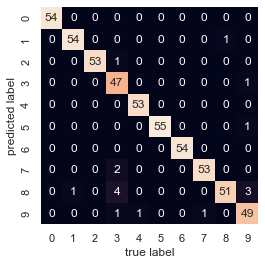

In [24]:
Y_pred = svm_clf.predict(X_test)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=digits.target_names,
        yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Linear Kernel

In [25]:
# Hyperparameter Tuning for Linear Kernel
param_grid = {'C': sp_rand(0,1000), 
              'gamma': sp_rand(0,50), 
              'kernel': ['linear']} 

rsearch = RandomizedSearchCV(SVC(), param_grid, n_iter=1000, cv=3)
rsearch.fit(X_trn, Y_trn)


best_params = rsearch.best_params_
print(f"Best params: {best_params}")

Best params: {'C': 0.28047450087842485, 'gamma': 12.703203686996483, 'kernel': 'linear'}


#### Performance of Tuned SVC with Linear Kernel

In [26]:
# Performance
svm_clf = SVC(**best_params)
svm_clf.fit(X_trn, Y_trn)
print_score(svm_clf, X_trn, Y_trn, X_test, Y_test, train=True)
print_score(svm_clf, X_trn, Y_trn, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 99.05%
_______________________________________________
CLASSIFICATION REPORT:
               0           1      2           3           4           5  \
precision    1.0    0.954545    1.0    0.992188    0.992188    0.992126   
recall       1.0    0.992126    1.0    0.992188    1.000000    0.992126   
f1-score     1.0    0.972973    1.0    0.992188    0.996078    0.992126   
support    124.0  127.000000  124.0  128.000000  127.000000  127.000000   

               6      7           8           9  accuracy    macro avg  \
precision    1.0    1.0    0.983051    0.991935  0.990453     0.990603   
recall       1.0    1.0    0.950820    0.976190  0.990453     0.990345   
f1-score     1.0    1.0    0.966667    0.984000  0.990453     0.990403   
support    127.0  125.0  122.000000  126.000000  0.990453  1257.000000   

           weighted avg  
precision      0.990574  
recall         0.990453  
f1-score       0.990443  
support     1257.000000  
_______________

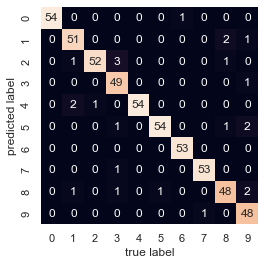

In [27]:
Y_pred = svm_clf.predict(X_test)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=digits.target_names,
        yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Radial Basis Function Kernel

In [28]:
# Hyperparameter Tuning for Polynomial Kernel
param_grid = {'C': sp_rand(0,1000), 
              'gamma': sp_rand(0,50), 
              'kernel': ['rbf']} 

rsearch = RandomizedSearchCV(SVC(), param_grid, n_iter=1000, cv=3)
rsearch.fit(X_trn, Y_trn)


best_params = rsearch.best_params_
print(f"Best params: {best_params}")

Best params: {'C': 718.020261898835, 'gamma': 0.05346463133614199, 'kernel': 'rbf'}


#### Performance of Tuned SVC with RBF Kernel

In [20]:
# Performance
svm_clf = SVC(**best_params)
svm_clf.fit(X_trn, Y_trn)
print_score(svm_clf, X_trn, Y_trn, X_test, Y_test, train=True)
print_score(svm_clf, X_trn, Y_trn, X_test, Y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1      2      3      4      5      6      7      8  \
precision    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
recall       1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
f1-score     1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
support    124.0  127.0  124.0  128.0  127.0  127.0  127.0  125.0  122.0   

               9  accuracy  macro avg  weighted avg  
precision    1.0       1.0        1.0           1.0  
recall       1.0       1.0        1.0           1.0  
f1-score     1.0       1.0        1.0           1.0  
support    126.0       1.0     1257.0        1257.0  
_______________________________________________
Confusion Matrix: 
 [[124   0   0   0   0   0   0   0   0   0]
 [  0 127   0   0   0   0   0   0   0   0]
 [  0   0 124   0   0   0   0   0   0   0]
 [  0   0   0 128   0   0   0   0   0   0]


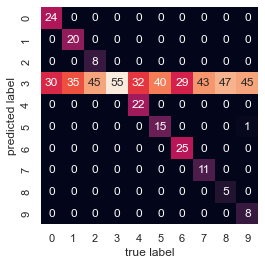

In [21]:
Y_pred = svm_clf.predict(X_test)
mat = confusion_matrix(Y_test, Y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=digits.target_names,
        yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');